# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

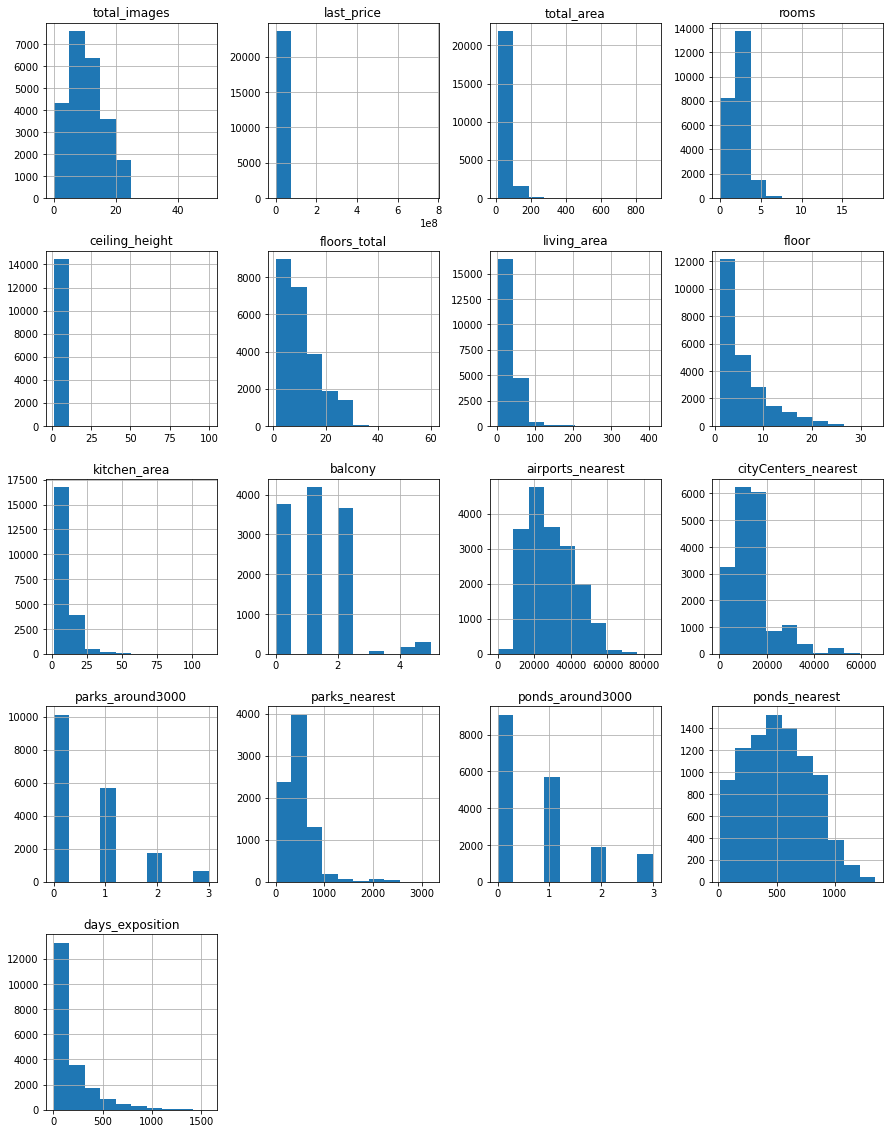

In [2]:
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except Exception:
    data = pd.read_csv('/datasets/real_estate_data.csv', '\t')
finally:
    data.hist(figsize=(15, 20));

## Предобработка данных

### Обработка пропусков

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Для наглядности построим визуализацию пропущенных значений по столбцам.

In [4]:
def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
        .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
    );    

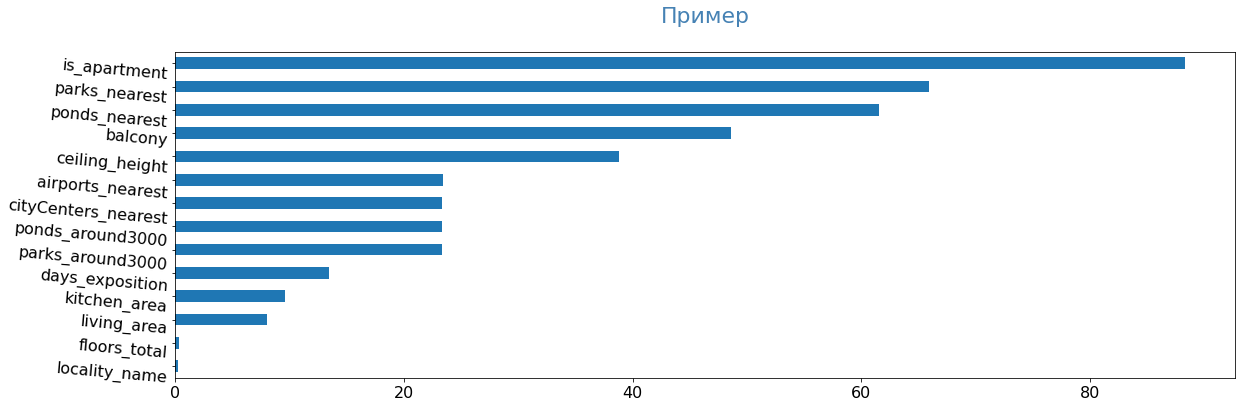

In [5]:
pass_value_barh(data)

Очень большое количество пропусков в столбцах is_apartment, parks_nearest, ponds_nearest.
Так же пропуски в столбцах ceiling_height, floors_total, living_area, kitchen_area, balcony, locality_name, airports_nearest, airports_nearest, parks_around3000, days_exposition.

Пропуски связанные с характеристикой квартиры, например высота потолков, колчество этажей в доме или площадь кухни, могли появиться из-за того что человек, заполняющий объявления просто не передал данные параметры. А пропуски в картографических данных, таких как расстояние до парка или водоёма, могли появиться, например, из-за ошибки в передаче данных из системы, которая их генерирует. 

Для начала заменим пропуски в значених, в которых отсутствие данных скорее всего означает что они равны нулю. Это столбцы определющие апартаменты, наличие балкона и наличие парков и водоемов в пределах 3км.

In [6]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [7]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)
data['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

In [8]:
data['balcony'] = data['balcony'].fillna(0).astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

In [9]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Удалим пропуски в столбце `floors_total`, их мы не можем заполнить и их дотсточно мало, чтобы это не повлияло на исследование.

In [10]:
data['floors_total'].count()

23613

In [11]:
data = data.dropna(subset=['floors_total'])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        14495 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Далее заполним пропуски медианными значениями в тех столбцах, где это будет уместно.

In [13]:
data['ceiling_height'].describe()

count    14495.000000
mean         2.771495
std          1.261445
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [14]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].describe()

count    23613.000000
mean         2.724581
std          0.990085
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Пропуски в столбцах с расстояниями до центра, парков и водоёмов считаю будет некорректо заполнять медианными значениями, так как пропусков слишком много, в этом случае в дальнейшем анализ будет не точным.

### Изменение типов данных

В некоторых столбцах для удобства дальнейшей работы необходимо изменить тип данных. Так в столбце `first_day_exposition` тип данных object можно преревести в datetime для того чтобы в дальнейшем с ним можно при необходимости проводить арифметичекие операции. 

In [15]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


И заменим формат данных float64 на целочисленный, там где не предполагается дробей.

In [16]:
data['last_price'] = data['last_price'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')

### Устранение дубликатов

In [17]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [18]:
len(data['locality_name'].unique())

365

In [19]:
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')\
    .str.replace('деревня', 'посёлок')\
    .str.replace('село', 'посёлок')\
    .str.replace('поселок городского типа', 'посёлок')\
    .str.replace('посёлок городского типа', 'посёлок')\
    .str.replace('коттеджный поселок', 'посёлок')\
    .str.replace('коттеджный посёлок', 'посёлок')\
    .str.replace('садовое товарищество', 'посёлок')\
    .str.replace('городской поселок', 'посёлок')\
    .str.replace('городской посёлок', 'посёлок')\
    .str.replace('деревня Кудрово', 'Кудрово')\
    .str.replace('посёлок Мурино', 'Мурино')\
    .str.replace('посёлок при железнодорожной станции', 'посёлок')\
    .str.replace('посёлок станции', 'посёлок')


Проверим от скольких дубликатов мы избавились

In [20]:
len(data['locality_name'].unique())

309

In [21]:
data.duplicated().sum()

0

### Обработка аномальных значений

In [22]:
data['ceiling_height'].unique()

array([  2.7 ,   2.65,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,   2.45,
         3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,
         3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,   5.  ,
         2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,
         4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,   3.18,
         3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,
         3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,
         3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,
        32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,
      

In [23]:
data['ceiling_height'].describe()

count    23613.000000
mean         2.724581
std          0.990085
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [24]:
def check_celling_height(row):
    if row > 10:
        row = row / 10
    return row

In [25]:
data['ceiling_height'] = data['ceiling_height'].apply(check_celling_height)

In [26]:
data['ceiling_height'].describe()

count    23613.000000
mean         2.697923
std          0.238047
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         10.000000
Name: ceiling_height, dtype: float64

In [27]:
data.query('ceiling_height < 2 or ceiling_height > 5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
464,15,66571000,280.3,2015-06-11,6,5.20,8,159.5,7,False,...,21.10,0,Санкт-Петербург,26316.0,6655.0,3,187.0,1,616.0,578.0
1026,20,155000000,310.0,2018-10-12,5,5.30,3,190.0,3,False,...,63.00,2,Санкт-Петербург,24899.0,4785.0,0,NaN,1,603.0,NaN
1388,20,59800000,399.0,2015-01-21,5,5.60,6,NaN,6,False,...,NaN,0,Санкт-Петербург,26204.0,6934.0,2,149.0,2,577.0,719.0
3474,3,1400000,30.0,2018-03-16,1,8.00,5,15.3,2,False,...,7.30,0,посёлок Нурма,NaN,NaN,0,NaN,0,NaN,125.0
5712,5,1500000,42.8,2017-08-14,2,1.20,2,27.5,1,False,...,5.20,0,посёлок Мга,NaN,NaN,0,NaN,0,NaN,248.0
5863,20,5650000,45.0,2018-08-15,1,8.30,16,19.3,14,False,...,8.30,1,Санкт-Петербург,13069.0,10763.0,0,NaN,1,613.0,14.0
7578,17,38000000,143.0,2017-11-02,3,5.50,5,83.0,5,False,...,29.00,1,Санкт-Петербург,26333.0,6448.0,3,479.0,0,NaN,NaN
12628,14,3900000,50.0,2018-03-29,1,5.30,5,NaN,5,False,...,NaN,0,Санкт-Петербург,19644.0,3918.0,1,505.0,1,92.0,8.0
15061,19,5600000,56.4,2018-05-11,2,1.40,14,32.4,5,False,...,9.10,2,Санкт-Петербург,14814.0,13610.0,0,NaN,0,NaN,315.0
15743,14,5600000,67.0,2016-11-11,3,8.00,16,41.0,1,False,...,8.00,0,Санкт-Петербург,32691.0,11035.0,1,723.0,0,NaN,474.0


In [28]:
len(data.query('ceiling_height < 2 or ceiling_height > 5')) / len(data) * 100

0.07199424046076314

Убирая выбросы из данного столбца мы уменьшаем наш датафрейм на 0,07%.

In [29]:
data = data.query('ceiling_height > 2 and ceiling_height < 5')

In [30]:
data['ceiling_height'].describe()

count    23583.000000
mean         2.696420
std          0.215059
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.900000
Name: ceiling_height, dtype: float64

Проверим другие столбцы на наличие выбросов.


Общая площадь квартиры

In [31]:
data['total_area'].describe()

count    23583.000000
mean        60.309974
std         35.517220
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

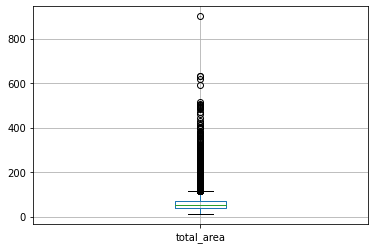

In [32]:
data.boxplot(column='total_area');

In [33]:
len(data.query('total_area > 200')) / len(data) * 100

0.9455964041894586

Избавляясь от выбросов в данном столбце мы теряем 0,9% от всех данных.

In [34]:
data = data.query('total_area < 200')

In [35]:
data['total_area'].describe()

count    23356.000000
mean        58.150241
std         26.450655
min         12.000000
25%         40.000000
50%         51.800000
75%         68.900000
max        199.200000
Name: total_area, dtype: float64

Жилая площадь

In [36]:
data['living_area'].describe()

count    21519.000000
mean        33.244501
std         17.329260
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

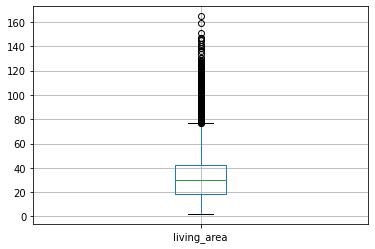

In [37]:
data.boxplot(column='living_area');

In [38]:
len(data.query('living_area < 5 or living_area > 100')) / len(data) * 100

0.7449905805788662

Избавляясь от выбросов в данном столбце мы теряем 0,7% данных.

In [39]:
# check
data.shape

(23356, 22)

In [40]:
data = data.query('(living_area > 5 & living_area < 100) | living_area.isnull()', engine='python')

In [41]:
# check
data.shape

(23172, 22)

In [42]:
data['living_area'].describe()

count    21335.000000
mean        32.572404
std         15.679994
min          5.400000
25%         18.500000
50%         30.000000
75%         42.000000
max         99.900000
Name: living_area, dtype: float64

Площадь кухни

In [43]:
data['kitchen_area'].describe()

count    20985.000000
mean        10.315239
std          5.297978
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max         93.200000
Name: kitchen_area, dtype: float64

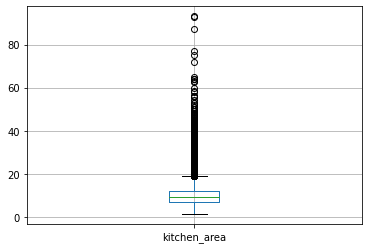

In [44]:
data.boxplot(column='kitchen_area');

In [45]:
len(data.query('kitchen_area > 30')) / len(data) * 100

1.0573105472121525

Избавляясь от выбросов в данным столбце мы потеряем 1% от всех данных.

In [46]:
# check
data.shape

(23172, 22)

In [47]:
data = data.query('kitchen_area < 30 | kitchen_area.isnull()', engine='python')

In [48]:
# check
data.shape

(22880, 22)

In [49]:
data['kitchen_area'].describe()

count    20693.000000
mean         9.912348
std          3.922823
min          1.300000
25%          7.000000
50%          9.000000
75%         11.500000
max         29.900000
Name: kitchen_area, dtype: float64

In [50]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22880 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22880 non-null  int64         
 1   last_price            22880 non-null  int64         
 2   total_area            22880 non-null  float64       
 3   first_day_exposition  22880 non-null  datetime64[ns]
 4   rooms                 22880 non-null  int64         
 5   ceiling_height        22880 non-null  float64       
 6   floors_total          22880 non-null  int64         
 7   living_area           21060 non-null  float64       
 8   floor                 22880 non-null  int64         
 9   is_apartment          22880 non-null  bool          
 10  studio                22880 non-null  bool          
 11  open_plan             22880 non-null  bool          
 12  kitchen_area          20693 non-null  float64       
 13  balcony         

Проверим какие аномалии остались.

In [51]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных показателях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,880.00","22,880.00","22,880.00","19,898.00","22,880.00","21,060.00","20,693.00","22,880.00","22,880.00"
min,0.00,12.00,2.20,1.00,"430,000.00",5.40,1.30,1.00,1.00
max,7.00,199.20,4.80,"1,580.00","124,000,000.00",99.90,29.90,33.00,60.00


Избавимся от выбивающихся значений в столбце `floors_total`.

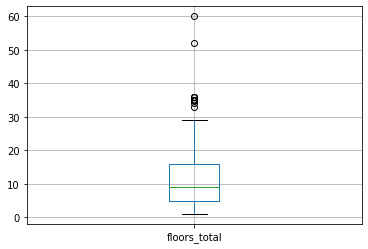

In [52]:
data.boxplot(column='floors_total');

In [53]:
data.shape

(22880, 22)

In [54]:
len(data.query('floors_total > 30')) / len(data) * 100

0.13548951048951047

In [55]:
data = data.query('floors_total < 30')

In [56]:
data.shape

(22849, 22)

## Посчитайте и добавьте в таблицу новые столбцы

In [57]:
data['square_meter_price'] = data['last_price'] / data['total_area']
data['square_meter_price'] = data['square_meter_price'].round()

In [58]:
data['week_day_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

In [59]:
data['month_of_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [60]:
data['year_of_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year

In [61]:
def check_floor(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

In [62]:
data['floor_type'] = data.apply(check_floor, axis=1)

In [63]:
data['cityCenters_nearest_in_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest_in_km'] = data['cityCenters_nearest_in_km'].round()

In [64]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,week_day_exposition,month_of_exposition,year_of_exposition,floor_type,cityCenters_nearest_in_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,NaN,120370.0,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0,NaN,81.0,82921.0,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2,574.0,558.0,92786.0,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,NaN,9,False,...,84.0,3,234.0,424.0,408176.0,4,7,2015,другой,7.0
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,0,NaN,55.0,95066.0,0,9,2018,другой,NaN


## Проведите исследовательский анализ данных

### Изучение параметров объектов

_Общая площадь_

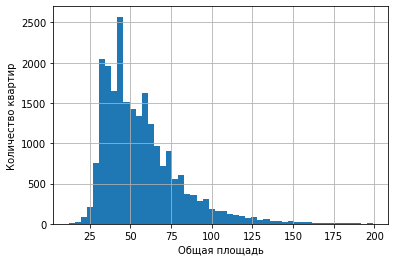

In [65]:
ax = data['total_area'].hist(bins=50);
ax.set_xlabel('Общая площадь');
ax.set_ylabel('Количество квартир');

На гистограмме видны три пика: один основной в значении примерно 45 квадратных метров, второй поменьше в значении около 30 квадратных метров и третий в значении примерно 55 квадратных метров.

_Жилая площадь_

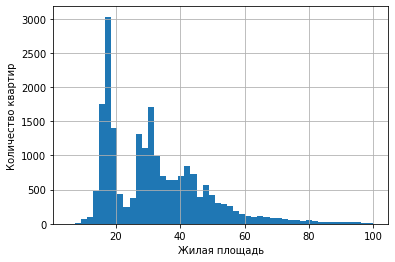

In [66]:
ax = data['living_area'].hist(bins=50)
ax.set_xlabel('Жилая площадь');
ax.set_ylabel('Количество квартир');

Видны два пика: самый большой в значении примерно 18 метров квадратных, и второй в значении примерно 30 метров квадратных. Между ними очень мало значений 22-23 метра квадратных.

_Площадь кухни_

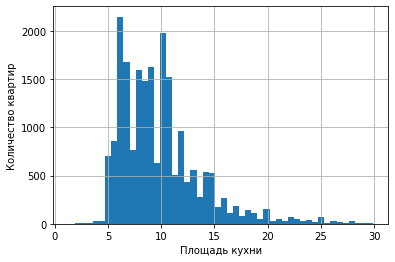

In [67]:
ax = data['kitchen_area'].hist(bins=50);
ax.set_xlabel('Площадь кухни');
ax.set_ylabel('Количество квартир');

На гистограмме видна неоднородность данных. Это может быть связано с типовыми планировками, в квартирах с одинаковой комнатностью может быть примерно одинаковая плащадь кухни. Пики расположены на отметках в 6 метров, 8 и 9 метров, 10 метров и 12. 

_Цена объекта_

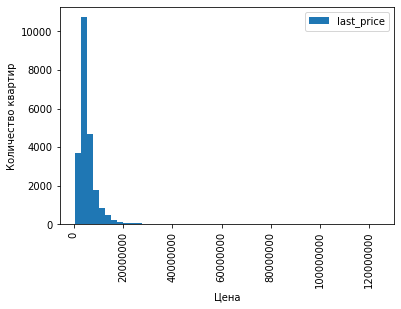

In [68]:
ax = data.plot(y='last_price', kind='hist', bins=50, rot=90);
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_xlabel('Цена');
ax.set_ylabel('Количество квартир');

Виден один большой пик на отметке примерно 5 млн.

_Количество комнат_

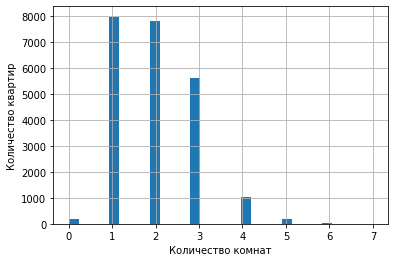

In [69]:
ax = data['rooms'].hist(bins=30)
ax.set_xlabel('Количество комнат');
ax.set_ylabel('Количество квартир');

Видно что количество однокомнатных и двухкомнатных квартир примерно совпадает, меньше всего квартир с пятью и шестью комнатами.

_Высота потолков_

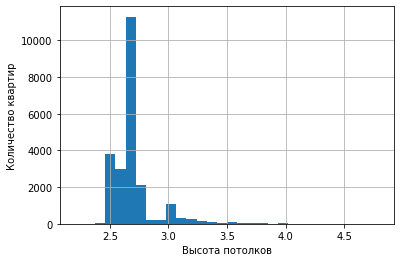

In [70]:
ax = data['ceiling_height'].hist(bins=30)
ax.set_xlabel('Высота потолков');
ax.set_ylabel('Количество квартир');

Подавляющее большинство квартир с высотой потолка 2,7 метров. так же два небольших пика в отметку 2,5 и 3 метра.

_Этаж квартиры_

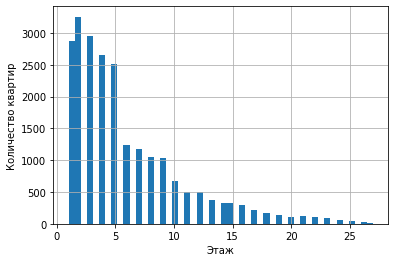

In [71]:
ax = data['floor'].hist(bins=50)
ax.set_xlabel('Этаж');
ax.set_ylabel('Количество квартир');

Большинсвто квартир расположено на первых трёх этажах.

_Тип этажа квартиры_

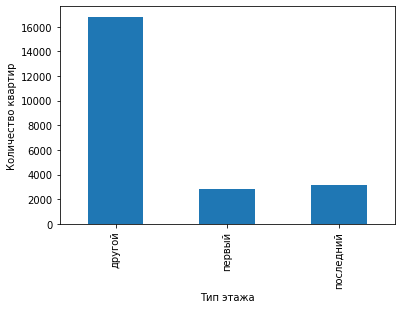

In [72]:
ax = data.groupby('floor_type')['floor_type'].count().plot.bar();
ax.set_xlabel('Тип этажа')
ax.set_ylabel('Количество квартир');

Чаше всего встречаются квартиры не на первом и не на последнем этаже.

_Количество этажей в доме_

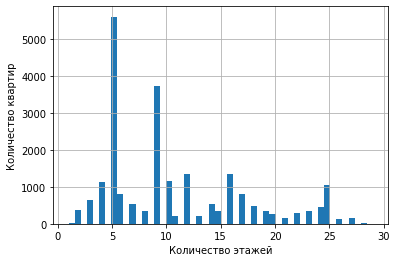

In [73]:
ax = data['floors_total'].hist(bins=50)
ax.set_xlabel('Количество этажей');
ax.set_ylabel('Количество квартир');

Больше всего домов с пятью и девятью этажами.

_Расстояние до центра в метрах_

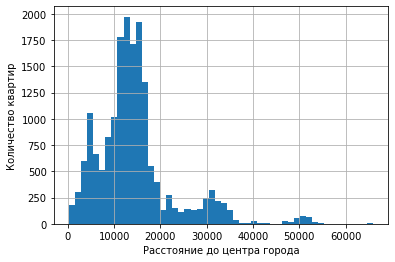

In [74]:
ax = data['cityCenters_nearest'].hist(bins=50)
ax.set_xlabel('Расстояние до центра города');
ax.set_ylabel('Количество квартир');

Небольшой пик в районе 4-5 тысяч метров, квартиры расположены недалеко от центра. И основной пик в районе 12 и 14 тысяч метров.

_Расстояние до ближайшего аэропорта_

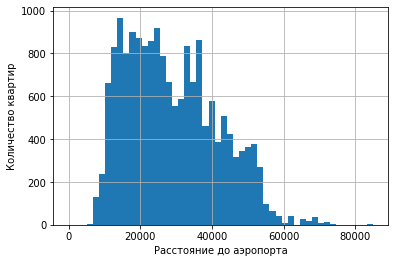

In [75]:
ax = data['airports_nearest'].hist(bins=50)
ax.set_xlabel('Расстояние до аэропорта');
ax.set_ylabel('Количество квартир');

Данные давольно однородные, большенство квартир расположены на расстоянии от 12 до 37 тыс метров.

_Расстояние до ближайшего парка_

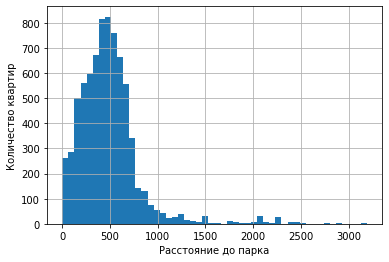

In [76]:
ax = data['parks_nearest'].hist(bins=50)
ax.set_xlabel('Расстояние до парка');
ax.set_ylabel('Количество квартир');

У большинства квартир парк находится в пределах тысячи метров, но основной пик можно наблюдать на отметке 400-500 метров.

_День публикации объявления_

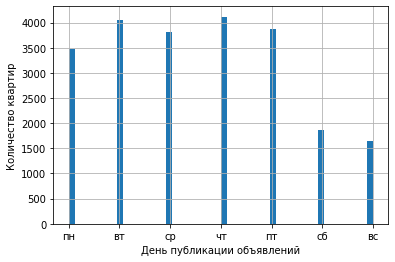

In [77]:
ax = data['week_day_exposition'].hist(bins=50)
plt.xticks(sorted(data['week_day_exposition'].unique().tolist()), ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']);
ax.set_xlabel('День публикации объявлений');
ax.set_ylabel('Количество квартир');

Чаще всего объявления выкладывают в четверг, чуть реже, но тоже часто во вторник. Редко новые объявления публикуются на выходных, в частоности по воскресеньям публикаций меньше всего.


_Месяц публикации объявления_

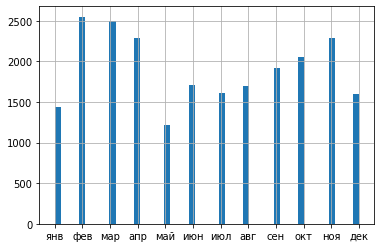

In [78]:
data['month_of_exposition'].hist(bins=50)
plt.xticks(sorted(data['month_of_exposition'].unique().tolist()), ['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']);
ax.set_xlabel('Месяц публикации объявлений');
ax.set_ylabel('Количество квартир');

Большая часть побликаций объявлений приходится на февраль. Так же часто объявления публикуются в марте, апреле и ноябре. Реже всего в мае.

### Изучение скорости продажи квартир

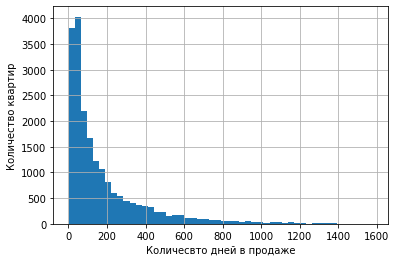

In [79]:
ax = data['days_exposition'].hist(bins=50)
ax.set_xlabel('Количесвто дней в продаже');
ax.set_ylabel('Количество квартир');

Из гистограммы можно сделать вывод, что большенство квартир продаются примерно за два месяца с момента публикации.

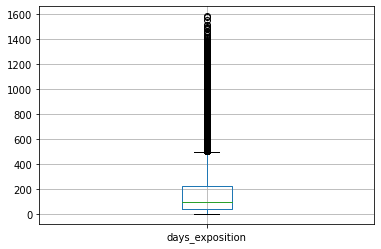

In [80]:
data.boxplot(column='days_exposition');

In [81]:
data['days_exposition'].describe()

count    19874.000000
mean       177.771209
std        216.388217
min          1.000000
25%         44.000000
50%         93.000000
75%        226.750000
max       1580.000000
Name: days_exposition, dtype: float64

In [82]:
print(f'Среднее равно {round(data["days_exposition"].mean(), 2)}')
print(f'Медиана равна {round(data["days_exposition"].median(), 2)}')

Среднее равно 177.77
Медиана равна 93.0


In [83]:
len(data.query('days_exposition > 500')) / len(data) * 100 

7.1688038863845245

Среднее значение выше медианы почти в два раза, а так же высокое значение стандартного отклонения может говорить о наличии выбросов. Из диаграммы размаха можно сделать вывод о том, что значения выше 500 дней являются выделяющимися и их можно считать аномально долгими продажами. Так как у нас нет информации о ликвидности квартир, или, например, о том к какому классу они относятся, можно предположить что квартиры с плохими внешними характеристиками, проблемами с документами, или относящиеся к классу бизнес могут продаваться 1,5 а то и 2 года. Бастрыми продажами можно считать объявления, снятые спустя менее чем 2 месяца после публикации.

### Исследование факторов, влияющих на стоимость квартиры

_Зависимость цены от общей площади_

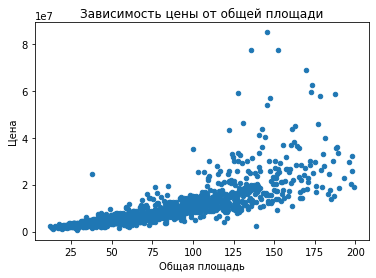

In [84]:
(
    data.pivot_table(index='total_area', values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='total_area', y='last_price', title='Зависимость цены от общей площади', kind='scatter')
);
plt.xlabel('Общая площадь');
plt.ylabel('Цена');

In [85]:
data['last_price'].corr(data['total_area'])

0.7065395772766953

Видна прямая зависимость, что подтверждает высокий коэфициент корреляции. Так же видны и выбивающиеся зависимости, напрмер квартира с площадью 37 квадратных метров с ценой сильно выше квартир схожих по площади, а так же квартиры с площадью выше 12 метров квадратных и ценой на том же уровне что и квартиры до 50 метров квадратных

_Зависимость цены от жилой площади_

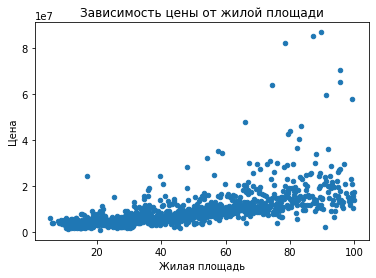

In [86]:
(
    data.pivot_table(index='living_area', values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='living_area', y='last_price', title='Зависимость цены от жилой площади', kind='scatter')
);
plt.xlabel('Жилая площадь');
plt.ylabel('Цена');

In [87]:
data['last_price'].corr(data['living_area'])

0.603282586937736

Коэфициент корреляции показывает заметную связь цены квартиры и жилой площади, но менее выражунную, чем зависимость цены и общей площади.

_Зависимость цены от площади кухни_

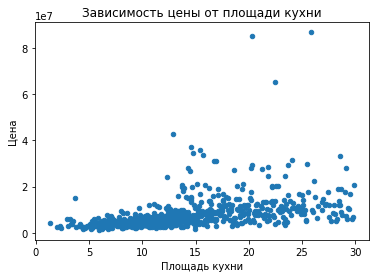

In [88]:
(
    data.pivot_table(index='kitchen_area', values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='kitchen_area', y='last_price', title='Зависимость цены от площади кухни', kind='scatter')
);
plt.xlabel('Площадь кухни');
plt.ylabel('Цена');

In [89]:
data['kitchen_area'].corr(data['living_area'])

0.29807337798523276

Зависимость цены квартиры от площади кухни слабая.


_Зависимость цены от количества комнат_

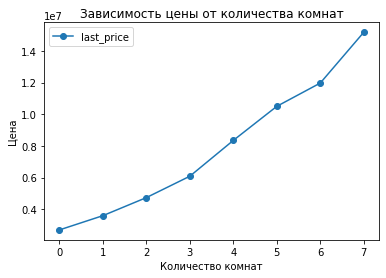

In [90]:
(
    data.pivot_table(index='rooms', values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='rooms', y='last_price', style='o-', title='Зависимость цены от количества комнат')
);
plt.xlabel('Количество комнат');
plt.ylabel('Цена');

In [91]:
data['last_price'].corr(data['rooms'])

0.41098671360215744

На графике видна прямая зависимость: чем больше комнат - тем выше стоимость квартиры. Коэфициент корреляции показывает умеренную зависимость, но гораздо меньшую чем, например, зависимость от площади. И действительно само по себе количество комнат не влияет так сильно на стоимость квартиры, так как значение имеет так же размер этих комнат и их удобство.

_Зависимость цены от этажа_

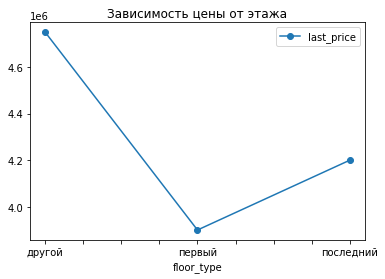

In [92]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(style='o-', title='Зависимость цены от этажа');

Очевидная зависимость: располодение квартиры на первом этаже сильно снижает ее рыночную стоимость.Но не стоит забывать о том, что в предыдущей части исследования мы выяснили что данные силько скошены в сторону квартир расположенных не на первом и не на последнем этажах.

_Зависимость цены от даты размещения_

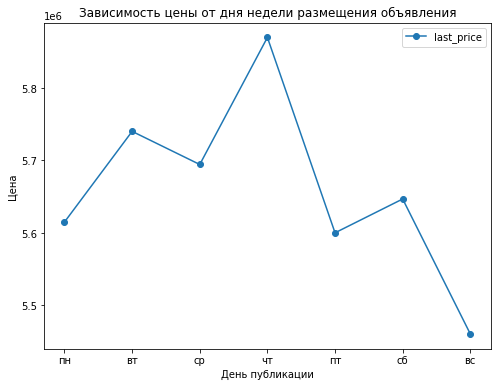

In [93]:
data.pivot_table(index='week_day_exposition', values='last_price').plot(style='o-', title='Зависимость цены от дня недели размещения объявления', figsize=(8, 6))
plt.xticks(sorted(data['week_day_exposition'].unique().tolist()), ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']);
plt.xlabel('День публикации');
plt.ylabel('Цена');

По четвергам публикуются более дорогие квартиры. Но опять же, опираясь на придыдущую часть исследвания, помним о том что в четверг выкладывается наибольшее количество объявлений. А по выходным объявления выкладывают меньше и с более низкой ценой.

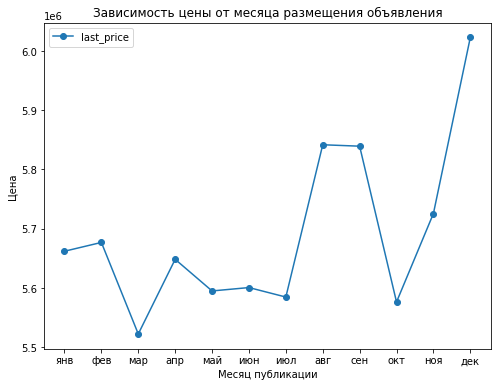

In [94]:
data.pivot_table(index='month_of_exposition', values='last_price').plot(style='o-', title='Зависимость цены от месяца размещения объявления', figsize=(8, 6))
plt.xticks(sorted(data['month_of_exposition'].unique().tolist()), ['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
plt.xlabel('Месяц публикации');
plt.ylabel('Цена');

Можно наблюдать сильный рост цен на квартиры в декабре. Так же заметен рыночный скачек в августе и сентябре. 

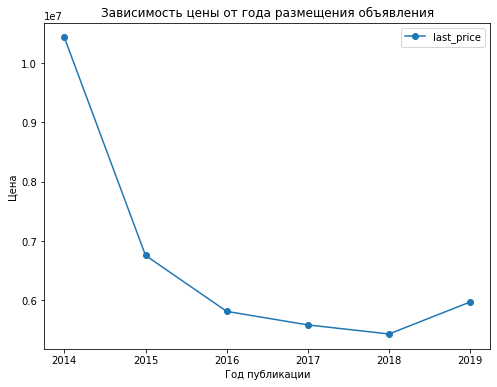

In [95]:
data.pivot_table(index='year_of_exposition', values='last_price').plot(style='o-', title='Зависимость цены от года размещения объявления', figsize=(8, 6))
plt.xlabel('Год публикации');
plt.ylabel('Цена');

Можно наблюдать падение цен после 2014г и до 2018. На это может влиять тот факт, что в 2014 году сервисом пользовалась лишь малая часть людей, стоимость недвижимости у которых была выше средней по рынку (и медиана выше), а в последующие годы пользователей становилось больше и медианный уровень цены стал снижаться. В 2019г наблюдается рост цен на квартиры.

### Анализ десяти населённых пунктов с наибольшим числом объявлений

In [96]:
top_10 = data.pivot_table(index='locality_name', values='square_meter_price', aggfunc=['mean', 'count'])
top_10.columns = ['mean', 'count']

In [97]:
top_10 = top_10.sort_values('count', ascending=False)[0:10]
top_10['mean'] = top_10['mean'].round()

In [98]:
top_10

,mean,count
locality_name,,
Санкт-Петербург,111952.0,14954
Мурино,86015.0,584
посёлок Шушары,78628.0,437
Всеволожск,68609.0,394
Пушкин,102490.0,355
Колпино,75333.0,337
посёлок Парголово,90332.0,326
Гатчина,68728.0,305
посёлок Кудрово,92542.0,298


In [99]:
print(f'Минимальная стоимость квадратного метра в населенном пункте: {top_10["mean"].idxmin()}')
print(f'Максимальная стоимость квадратного метра в населенном пункте: {top_10["mean"].idxmax()}')

Минимальная стоимость квадратного метра в населенном пункте: Выборг
Максимальная стоимость квадратного метра в населенном пункте: Санкт-Петербург


In [100]:
# check
top_10 = top_10.sort_values(by='mean')
top_10

,mean,count
locality_name,,
Выборг,57966.0,231
Всеволожск,68609.0,394
Гатчина,68728.0,305
Колпино,75333.0,337
посёлок Шушары,78628.0,437
Мурино,86015.0,584
посёлок Парголово,90332.0,326
посёлок Кудрово,92542.0,298
Пушкин,102490.0,355


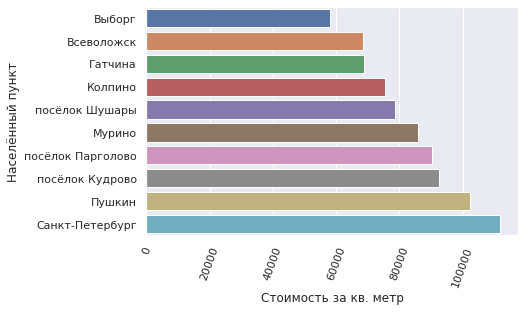

In [101]:
seaborn.set(font_scale=1)
plt.xticks(rotation=70)
plt.tight_layout()
seaborn.barplot(x=top_10['mean'], y=top_10.index, orient='h');
plt.xlabel('Cтоимость за кв. метр');
plt.ylabel('Населённый пункт');

Ожидаемо самая высокая стоимость за квадратный метр оказалась в Санкт-Петербурге, за ним Пушкин и Кудрово. Самая низкая цена за квадратный метр в Гатчине.

### Анализ изменения цены квадратного метра в Санкт-Петербурге для каждого километра по степени удалённости от центра

In [102]:
spb = data.query('locality_name == "Санкт-Петербург"')

In [103]:
average_sqm_price_groupdby_to_citeCenters_nearest_in_km_spb = spb.pivot_table(index='cityCenters_nearest_in_km', values='square_meter_price', aggfunc='mean')

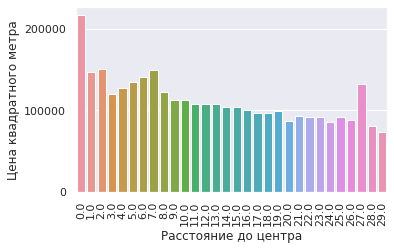

In [104]:
seaborn.barplot(
    x=average_sqm_price_groupdby_to_citeCenters_nearest_in_km_spb.index, 
    y=average_sqm_price_groupdby_to_citeCenters_nearest_in_km_spb['square_meter_price']
)
seaborn.set(font_scale=2)
plt.xticks(rotation=90)
plt.tight_layout()
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена квадратного метра');

In [105]:
spb['cityCenters_nearest_in_km'].corr(spb['square_meter_price'])

-0.33583448871962507

На графике наглядно видно, что самые дорогие квартиры расположены в самом центре города. Далее можно наблюдать отрицательную корреляцию, то есть с увеличеием расстояния до центра города снижается цена за квадратный метр. Так же видны выбивающиеся значения: увелиение стоимости квадратного метра на расстоянии 2 км, рост стоимости в диапазоне от 3 до 7 км, а так же неожиданный выпад в значении 27 км.

## Общий вывод

Мы проанализировали зависимость стоимости квартир в Санкт-Петербурге и Лен. области от разных параметров. Исходя из полученных данных мы можем выделить факторы, которые в большей степени виляют на рыночную стоимость квартир. 
К ним относятся:
 - Общая площадь
 - Тип этажа (первый, последний)
 - Месяц публикации объявления
 - Расположение
 
Эти параметры формируют ликвидность квартиры. От её площади зависит в том числе и количество комнат, спрос на квартиры на первых и последних этажах гораздно ниже из-за их особенностей, рынок недвижимости имеет свою сезонность и в связи с этим осенью и пред новым годом продать квартиру можно дороже, а инфраструктура Санкт-Петербурга централизвана, поэтому районы ближе к центру являются более привлекательными.